# RUN ALL CODE

### IMPORT LIBRARIES

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
!pip install abc_analysis
pd.options.display.float_format = '{:,.2f}'.format


!pip install lifetimes
!pip install lifetimes --upgrade
!pip install scikit-learn==1.0.2


from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error, r2_score


from lifetimes import \
    BetaGeoFitter, \
    GammaGammaFitter

from lifetimes.utils import \
    calibration_and_holdout_data,\
    summary_data_from_transaction_data, \
    calculate_alive_path

from lifetimes.plotting import\
     plot_frequency_recency_matrix, \
    plot_probability_alive_matrix, \
    plot_period_transactions, \
    plot_history_alive, \
    plot_cumulative_transactions, \
    plot_calibration_purchases_vs_holdout_purchases, \
    plot_transaction_rate_heterogeneity, \
    plot_dropout_rate_heterogeneity


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 KB 19.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### LOAD DATA

In [ ]:
all_data = pd.read_parquet('/content/drive/MyDrive/capstone/transactions_dataset.parquet')

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63319315 entries, 0 to 63319314
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   date_order     object 
 1   date_invoice   object 
 2   product_id     int64  
 3   client_id      int64  
 4   sales_net      float64
 5   quantity       int64  
 6   order_channel  object 
 7   branch_id      int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 3.8+ GB


In [ ]:
#here we will optimise the dataset and also create some new features. Although these features will not be used for now

def extract_dates(all_data):
    all_data['data_order_year']=all_data['date_order'].dt.year
    all_data['data_order_month']=all_data['date_order'].dt.month_name()
    all_data['data_order_dayofmonth']=all_data['date_order'].dt.day
    all_data['data_order_dayofweek']=all_data['date_order'].dt.day_name()
    all_data['month_year'] = all_data['date_order'].dt.strftime('%Y-%m')
    return all_data

def data_optimize(all_data):
    all_data.product_id= all_data.product_id.astype(np.int32)
    all_data.client_id= all_data.client_id.astype(np.int32)
    all_data.quantity= all_data.quantity.astype(np.int32)
    all_data.branch_id= all_data.branch_id.astype(np.int16)
    all_data.sales_net=all_data.sales_net.astype(np.float32)
    all_data['date_order'] =  pd.to_datetime(all_data['date_order'], format='%Y-%m-%d')
    all_data.order_channel= all_data.order_channel.astype('category')
    return all_data

all_data=(all_data
.pipe(data_optimize)
.pipe(extract_dates))

all_data.drop(['date_invoice', 'data_order_year', 'data_order_month', 'data_order_dayofmonth', 'data_order_dayofweek', 'month_year'], axis = 1, inplace = True)
all_data.head()

,date_order,product_id,client_id,sales_net,quantity,order_channel,branch_id
0,2017-09-25,2376333,188502,155.44,3,online,2732
1,2017-09-25,2520527,835089,16.39,3,at the store,10279
2,2017-09-25,2536756,1977896,365.77,21,online,6184
3,2017-09-25,3028673,598816,8.60,201,at the store,4200
4,2017-09-25,203377,2086861,"1,093.37",3,by phone,7051


### REFUNDS ANALYSIS

We considered negative transactions as refunds from clients. 

1. We identified some outliers within the 'quantity' column so we used a custom transaction id column built from concatenating date_order with client_id. 

2. By counting the trans_id column for each product, we could see how poor was the perfomance of some top_selling products.


In [ ]:
refunds = all_data[all_data['sales_net'] <= 0]
refunds.head()

In [ ]:
refunds.nunique()

date_order          731
product_id       159730
client_id        121707
sales_net        379609
quantity           1335
order_channel         5
branch_id           559
dtype: int64

In [ ]:
refunds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4804748 entries, 10 to 63319314
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date_order     datetime64[ns]
 1   product_id     int32         
 2   client_id      int32         
 3   sales_net      float32       
 4   quantity       int32         
 5   order_channel  category      
 6   branch_id      int16         
dtypes: category(1), datetime64[ns](1), float32(1), int16(1), int32(3)
memory usage: 160.4 MB


In [ ]:
all_data.nunique()

date_order           731
product_id        607418
client_id         170589
sales_net        2373912
quantity            3444
order_channel          5
branch_id            582
dtype: int64

In [ ]:
most_refunded = refunds.groupby('product_id').agg({'sales_net': 'sum', 'quantity': 'sum', 'product_id': 'count'}).rename(columns={'product_id': 'total_refunds'}).sort_values('total_refunds', ascending=False).reset_index()
all_refunds = most_refunded['total_refunds'].sum()
most_refunded['cumulative_refunds'] = most_refunded['total_refunds'].cumsum()
most_refunded['cumulative_refunds_pct'] = most_refunded['cumulative_refunds'] / all_refunds * 100
most_refunded.head()


,product_id,sales_net,quantity,total_refunds,cumulative_refunds,cumulative_refunds_pct
0,2512504,"-72,447.09",1296142,407534,407534,8.48
1,3000784,"-147,986.97",236462,56224,463758,9.65
2,1366829,"-108,448.20",1253738,52452,516210,10.74
3,1075327,"-20,131.79",106950,34826,551036,11.47
4,1895362,"-102,770.82",1058522,34148,585184,12.18


Top 30 products by negative sales_net

<Figure size 1440x1440 with 0 Axes>

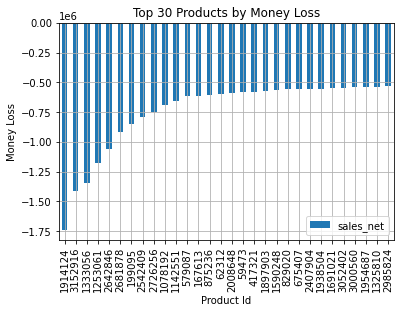

In [ ]:

plt.figure(figsize=(20,20))
top_30_refunded = most_refunded.sort_values(by='sales_net',ascending=True).head(30)
top_30_refunded.plot(kind='bar', x= 'product_id', y='sales_net', grid=True)
plt.xlabel('Product Id')
plt.ylabel('Money Loss')
plt.title('Top 30 Products by Money Loss')
plt.show()

Top 30 products by number of refunds

<Figure size 1440x1440 with 0 Axes>

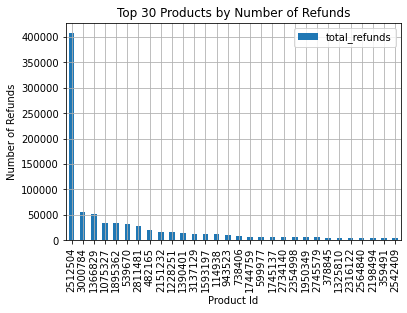

In [ ]:

plt.figure(figsize=(20,20))
top_30_refunded = most_refunded.sort_values(by='total_refunds',ascending=False).head(30)
top_30_refunded.plot(kind='bar', x= 'product_id', y='total_refunds', grid=True)
plt.xlabel('Product Id')
plt.ylabel('Number of Refunds')
plt.title('Top 30 Products by Number of Refunds')
plt.show()

In [ ]:
worst_channel = refunds.groupby('order_channel').agg({'sales_net': 'sum', 'product_id': 'count'}).rename(columns={'product_id': 'total_refunds'}).sort_values('total_refunds', ascending=False)
worst_channel.head()

,sales_net,total_refunds
order_channel,,
at the store,"-162,907,088.00",3198298
by phone,"-387,484,896.00",1480725
online,"-26,181,964.00",121497
during the visit of a sales rep,"-383,177.31",2509
other,"-337,093.75",1719


### PRODUCT SEGMENTATION ON ALL PRODUCTS WITH ABC ANALYSIS

Approach:

1. We took all products and grouped them by id
2. We sorted the products by total_sales in a descending way.
3. Hten two new columns were added, as their names suggest, the calculation comes from adding all sales until we reach to 100%
    1.1 cumulative_sales_net
    1.2 cumulative_sales_net_pct
4. Three labels were assigned to the products based on their sales perfomance. A,B and C.
A: 0% - 80% of Sales
B: 81% - 90% of Sales
C: 91 - 100% of Sales

5. With our labels, we could analyze separately the relationship between the top selling products and learn their prefered order channels and customer segments. 


In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63319315 entries, 0 to 63319314
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date_order     datetime64[ns]
 1   product_id     int32         
 2   client_id      int32         
 3   sales_net      float32       
 4   quantity       int32         
 5   order_channel  category      
 6   branch_id      int16         
dtypes: category(1), datetime64[ns](1), float32(1), int16(1), int32(3)
memory usage: 1.6 GB


In [ ]:
all_data = all_data[all_data['sales_net'] > 0]

In [ ]:
all_data.nunique()

date_order           731
product_id        605575
client_id         170586
sales_net        1994303
quantity            3413
order_channel          5
branch_id            582
dtype: int64

In [ ]:
grouped = all_data\
          .groupby(['product_id'])\
          .agg({'sales_net':'sum', 'quantity': 'sum'})\
          .reset_index()\
          .sort_values(by='sales_net', ascending=False)

grouped['cumulative_sales_net'] = grouped['sales_net'].cumsum()
grouped['cumulative_sales_net_pct'] = grouped['cumulative_sales_net'] / grouped['sales_net'].sum() * 100

In [ ]:
grouped.head()

,product_id,sales_net,quantity,cumulative_sales_net,cumulative_sales_net_pct
501253,2681878,"40,721,888.00",80476389,"40,721,888.00",0.41
86334,463156,"25,399,484.00",74553154,"66,121,372.00",0.66
475111,2542409,"24,159,422.00",37354177,"90,280,792.00",0.91
233910,1253061,"23,892,142.00",497131,"114,172,936.00",1.15
247463,1325810,"20,104,422.00",47058240,"134,277,360.00",1.35


In [ ]:
grouped.nunique()

product_id                  605575
sales_net                   352189
quantity                     22212
cumulative_sales_net        360640
cumulative_sales_net_pct    352522
dtype: int64

In [ ]:
grouped[grouped['cumulative_sales_net_pct'] <= 80].tail()

,product_id,sales_net,quantity,cumulative_sales_net,cumulative_sales_net_pct
161168,863446,"55,830.20",5,"7,955,658,752.00",80.00
67308,361688,"55,826.69",1048,"7,955,714,560.00",80.00
432661,2316628,"55,821.47",2064,"7,955,770,368.00",80.00
41860,225903,"55,816.38",12460,"7,955,826,176.00",80.00
445821,2386338,"55,813.19",225,"7,955,881,984.00",80.00


In [ ]:
grouped['ABC_group'] = 'C'
grouped.loc[grouped['cumulative_sales_net_pct'] <= 80, 'ABC_group'] = 'A'
grouped.loc[(grouped['cumulative_sales_net_pct'] > 80) & (grouped['cumulative_sales_net_pct'] <= 90), 'ABC_group'] = 'B'

grouped.head()

,product_id,sales_net,quantity,cumulative_sales_net,cumulative_sales_net_pct,ABC_group
501253,2681878,"40,721,888.00",80476389,"40,721,888.00",0.41,A
86334,463156,"25,399,484.00",74553154,"66,121,372.00",0.66,A
475111,2542409,"24,159,422.00",37354177,"90,280,792.00",0.91,A
233910,1253061,"23,892,142.00",497131,"114,172,936.00",1.15,A
247463,1325810,"20,104,422.00",47058240,"134,277,360.00",1.35,A


In [ ]:
plotabc = grouped['ABC_group'].value_counts().to_frame().reset_index().sort_values(by = 'index')
plotabc

,index,ABC_group
2,A,23551
1,B,34208
0,C,547816


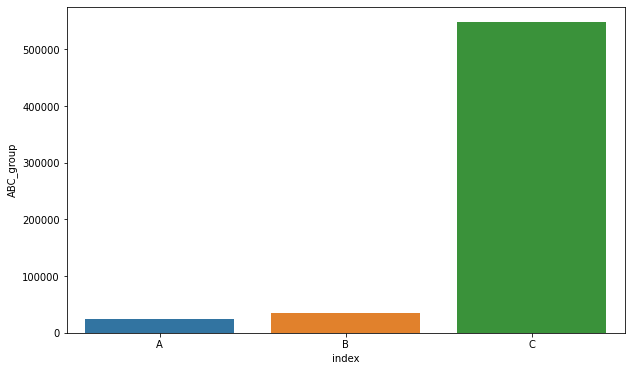

In [ ]:
plt.figure(figsize = (10,6))
sns.barplot(data = plotabc, x = 'index', y = 'ABC_group')

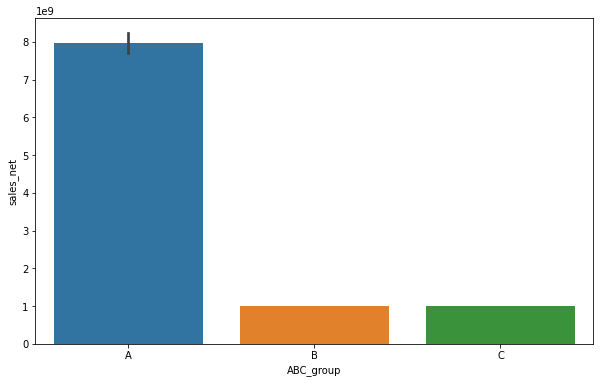

In [ ]:
plt.figure(figsize = (10,6))
sns.barplot(data=grouped, x='ABC_group', y='sales_net', estimator=sum)

In [ ]:
all_data = all_data.merge(grouped, on='product_id', how='left')

In [ ]:
grouped.nunique()

product_id                  605575
sales_net                   352189
quantity                     22212
cumulative_sales_net        360640
cumulative_sales_net_pct    352522
ABC_group                        3
dtype: int64

In [ ]:
grouped.sort_values(by = 'cumulative_sales_net_pct', ascending = True).head(10)

,product_id,sales_net,quantity,cumulative_sales_net,cumulative_sales_net_pct,ABC_group
501253,2681878,"40,721,888.00",80476389,"40,721,888.00",0.41,A
86334,463156,"25,399,484.00",74553154,"66,121,372.00",0.66,A
475111,2542409,"24,159,422.00",37354177,"90,280,792.00",0.91,A
233910,1253061,"23,892,142.00",497131,"114,172,936.00",1.15,A
247463,1325810,"20,104,422.00",47058240,"134,277,360.00",1.35,A
163387,875236,"19,772,694.00",3618021,"154,050,048.00",1.55,A
104431,560204,"17,819,438.00",33292361,"171,869,488.00",1.73,A
479251,2564840,"17,661,690.00",7672469,"189,531,184.00",1.91,A
364701,1954776,"16,291,514.00",4492938,"205,822,704.00",2.07,A
36940,199095,"16,204,791.00",5988,"222,027,488.00",2.23,A


In [ ]:
grouped.iloc[48000, :]

product_id                          2723103
sales_net                         20,464.70
quantity                                 95
cumulative_sales_net       8,776,736,768.00
cumulative_sales_net_pct              88.25
ABC_group                                 B
Name: 508873, dtype: object

In [ ]:
grouped.iloc[48500, :]

product_id                          1765812
sales_net                         20,153.89
quantity                                248
cumulative_sales_net       8,786,976,768.00
cumulative_sales_net_pct              88.36
ABC_group                                 B
Name: 329408, dtype: object

In [ ]:
all_data.shape

(58514567, 12)

### MODELING CUSTOMER LIFETIME VALUE

To calculate Customer Lifetime Value (CLV), we utilized the lifetimes library.

Firstly, we modeled the data to obtain the Recency, Frequency, and Age of each client, along with their average monetary value. 

Next, we applied the Beta-Geometric/Negative Binomial (BG/NBD) model to predict the number of future transactions a customer will make. This was done by splitting the data, and during the simulated data test, we observed that our predictions accurately aligned.

We then fit the BG/NBD model with all customers, and once again, the results were positive. 

To calculate the future spending value (CLV), we first checked for correlation between frequency and monetary value variables. With low correlation identified, we conducted the experiment using the Gamma Gamma model and compared the predictions against the actual value, evaluating with MAPE.

In [ ]:
df_labeled = pd.read_csv('/content/drive/MyDrive/capstone/data_jesus/customer_segments_spend_level.csv', sep = ',')

In [ ]:
all_data.drop(['sales_net_y', 'quantity_y'], axis = 1, inplace = True )
all_data.rename(columns = {'sales_net_x': 'sales_net', 'quantity_x': 'quantity'}, inplace = True)
all_data = all_data[all_data['sales_net'] > 0]
all_data.head()

,date_order,product_id,client_id,sales_net,quantity,order_channel,branch_id,cumulative_sales_net,cumulative_sales_net_pct,ABC_group
0,2017-09-25,2376333,188502,155.44,3,online,2732,"1,163,852,544.00",11.70,A
1,2017-09-25,2520527,835089,16.39,3,at the store,10279,"2,924,963,072.00",29.41,A
2,2017-09-25,2536756,1977896,365.77,21,online,6184,"2,974,808,832.00",29.91,A
3,2017-09-25,3028673,598816,8.60,201,at the store,4200,"4,365,448,192.00",43.90,A
4,2017-09-25,203377,2086861,"1,093.37",3,by phone,7051,"4,596,024,320.00",46.22,A


In [ ]:
summary = summary_data_from_transaction_data(all_data,
                                             "client_id",
                                             "date_order",
                                             monetary_value_col = 'sales_net',
                                             observation_period_end='2019-09-22')
summary.reset_index().head()

,client_id,frequency,recency,T,monetary_value
0,6,12.00,655.00,695.00,377.01
1,7,1.00,161.00,433.00,481.20
2,14,504.00,725.00,727.00,"6,246.71"
3,18,290.00,716.00,726.00,846.98
4,25,0.00,0.00,347.00,0.00


Using the calibration and observation split.

In [ ]:
from lifetimes.utils import calibration_and_holdout_data

rfm_cal_holdout = calibration_and_holdout_data(transactions = all_data,
                                               customer_id_col='client_id', 
                                               datetime_col='date_order',
                                               monetary_value_col = 'sales_net',
                                               calibration_period_end='2019-07-24',
                                               observation_period_end='2019-09-22',
                                               freq = 'D')

rfm_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
client_id,,,,,,,
6,9.00,474.00,635.00,237.14,3.00,199.15,60.00
7,1.00,161.00,373.00,481.20,0.00,0.00,60.00
14,463.00,666.00,667.00,"6,289.66",41.00,214.56,60.00
18,265.00,665.00,666.00,813.81,25.00,178.36,60.00
25,0.00,0.00,287.00,0.00,0.00,0.00,60.00


In [ ]:
rfm_cal_holdout.describe()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
count,"166,322.00","166,322.00","166,322.00","166,322.00","166,322.00","166,322.00","166,322.00"
mean,42.76,395.15,534.74,765.73,4.00,117.25,60.00
std,78.09,252.00,177.85,"3,637.49",7.55,457.16,0.00
min,0.00,0.00,1.00,0.00,0.00,0.00,60.00
25%,2.00,142.00,464.00,186.48,0.00,0.00,60.00
50%,11.00,480.00,628.00,430.00,1.00,31.91,60.00
75%,42.00,637.00,660.00,832.47,4.00,133.81,60.00
max,532.00,669.00,670.00,"865,702.38",46.00,"58,778.55",60.00


In [ ]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf = BetaGeoFitter(penalizer_coef=1e-06)

bgf.fit(
        frequency = rfm_cal_holdout['frequency_cal'],
        recency = rfm_cal_holdout['recency_cal'],
        T = rfm_cal_holdout['T_cal'], 
        weights = None,
        verbose = True, 
        tol = 1e-06)

Optimization terminated successfully.
         Current function value: -163.536905
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26


<lifetimes.BetaGeoFitter: fitted with 166322 subjects, a: 0.08, alpha: 6.09, b: 2.79, r: 0.48>

In [ ]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.48,0.00,0.48,0.49
alpha,6.09,0.03,6.03,6.14
a,0.08,0.00,0.08,0.08
b,2.79,0.06,2.66,2.91


<Figure size 864x864 with 0 Axes>

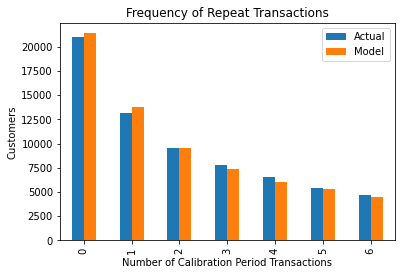

In [ ]:
from lifetimes.plotting import plot_period_transactions

fig = plt.figure(figsize=(12, 12))
plot_period_transactions(bgf);

<Figure size 504x504 with 0 Axes>

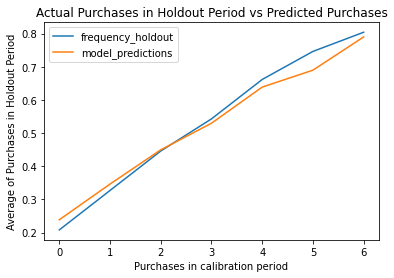

In [ ]:
# testing: predicted vs actual purchases in holdout period
fig = plt.figure(figsize=(7, 7)) 
plot_calibration_purchases_vs_holdout_purchases(bgf, rfm_cal_holdout);

TEST ON THE FULL DATASET

In [ ]:
# BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=1e-06)
bgf.fit(
        frequency = summary["frequency"], 
        recency = summary["recency"], 
        T = summary["T"],   
        weights = None,  
        verbose = True,   
        tol =1e-06)
pd.options.display.float_format = '{:,.3f}'.format
bgf.summary

Optimization terminated successfully.
         Current function value: -178.252790
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.482,0.002,0.478,0.485
alpha,6.140,0.030,6.081,6.198
a,0.084,0.001,0.083,0.086
b,3.065,0.070,2.927,3.203


In [ ]:
summary.shape

(170586, 4)

In [ ]:
rfm_cal_holdout.shape

(166322, 7)

575


<Figure size 864x864 with 0 Axes>

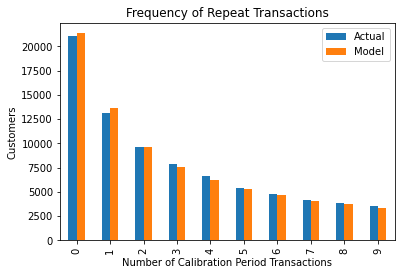

In [ ]:

max_freq = int(summary["frequency"].max())           
max_T = int(summary["T"].max())                         
max_rec = int(summary["recency"].max())  
print(max_freq)

# Model Evaluation with artificial data

fig = plt.figure(figsize=(12, 12))
plot_period_transactions(
            model = bgf,  
            max_frequency = 10);

In [ ]:
# Predict Customer's Purchases in the following 60 days


def predict_purch(df, t):
        df["predict_purch_" + str(t)] = \
                bgf.predict(
                    t, 
                    df["frequency"], 
                    df["recency"], 
                    df["T"])
                    
t_FC = [60]
_ = [predict_purch(summary, t) for t in t_FC]
pd.options.display.float_format = '{:,.1f}'.format

In [ ]:
# top 10 customers over next 60 days

print("top 10 customers, by their predicted purchases over next 60 days")
summary.sort_values(by="predict_purch_60", ascending=False).head(10)

top 10 customers, by their predicted purchases over next 60 days


,frequency,recency,T,monetary_value,predict_purch_60
client_id,,,,,
1162413,575.0,725.0,727.0,"2,530.6",46.9
705312,567.0,726.0,727.0,"6,133.8",46.3
1444500,559.0,725.0,727.0,"11,261.5",45.6
1890528,557.0,726.0,729.0,"2,351.6",45.3
1061219,552.0,727.0,729.0,"6,986.5",44.9
39877,548.0,725.0,727.0,"5,925.5",44.7
2056558,542.0,725.0,727.0,"4,268.6",44.2
335696,541.0,725.0,727.0,"1,969.6",44.1
955820,534.0,725.0,727.0,"5,866.7",43.6


In [ ]:
# For the Gamma Gamma Model to work properly, we can only work with customers that have a positive monetary value,
# But because we are working without the Refunds, we keep al customers that actually made a repeated purchase.


summary = summary[summary["monetary_value"] > 0]
pd.options.display.float_format = '{:,.2f}'.format
summary.describe()

,frequency,recency,T,monetary_value,predict_purch_60
count,"149,499.00","149,499.00","149,499.00","149,499.00","149,499.00"
mean,52.06,489.37,608.56,878.40,4.33
std,88.02,236.40,173.78,"3,381.91",7.26
min,1.00,1.00,3.00,0.06,0.00
25%,5.00,301.00,569.00,277.39,0.34
50%,15.00,590.00,697.00,508.35,1.31
75%,54.00,698.00,723.00,923.51,4.62
max,575.00,729.00,730.00,"575,825.50",46.91


In [ ]:
# Another important step is to make sure there is no correlation or a very low correlation between frequency and monetary value.

summary[['frequency', 'monetary_value']].corr()

,frequency,monetary_value
frequency,1.00,0.07
monetary_value,0.07,1.00


In [ ]:
# In this step we are fitting the Gamma Gamma model with all the customers. 
# As an output, we get the parameters the model uses. 

ggf = GammaGammaFitter(penalizer_coef =1e-06)
ggf.fit(
        frequency = summary["frequency"],
        monetary_value = summary["monetary_value"],  
        weights = None,   
        verbose = True,  
        tol = 1e-06,  
        q_constraint = True)
pd.options.display.float_format = '{:,.3f}'.format
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,3.178,0.022,3.134,3.221
q,1.417,0.005,1.408,1.427
v,162.655,1.250,160.206,165.104


In [ ]:
# Now that we have the predicted number of transactions by customer,
# we now use the Gamma Gamma model tu predict the average expected revenue from each customer
# This can be compared to the avg monetary value of our customers and measure using MAPE.

exp_avg_rev = ggf.conditional_expected_average_profit(
        summary["frequency"],
        summary["monetary_value"])

summary["exp_avg_rev"] = exp_avg_rev
summary["avg_rev"] = summary["monetary_value"]
summary["error_rev"] = summary["exp_avg_rev"] - summary["avg_rev"]

mape = mean_absolute_percentage_error(summary["monetary_value"],exp_avg_rev)
print("MAPE of predicted revenues:", f'{mape:.2f}')

pd.options.display.float_format = '{:,.3f}'.format
summary.head()

MAPE of predicted revenues: 0.31


,frequency,recency,T,monetary_value,predict_purch_60,exp_avg_rev,avg_rev,error_rev
client_id,,,,,,,,
6,12.000,655.000,695.000,377.012,1.052,386.340,377.012,9.328
7,1.000,161.000,433.000,481.204,0.181,569.139,481.204,87.935
14,504.000,725.000,727.000,"6,246.709",41.121,"6,245.405","6,246.709",-1.304
18,290.000,716.000,726.000,846.982,23.359,847.159,846.982,0.177
37,14.000,568.000,677.000,428.392,1.190,435.922,428.392,7.530


In [ ]:
# In this cell we calculate the Customer Lifetime value of the following 60 days out of sample. 

summary['CLV'] = ggf.customer_lifetime_value(
                          transaction_prediction_model = bgf,  
                          frequency = summary["frequency"],  
                          recency = summary["recency"],  
                          T = summary["T"],  
                          monetary_value = summary["monetary_value"],  
                          time = 2,    
                          freq = "D",                          
                          discount_rate = 0.00)
summary.describe().T

,count,mean,std,min,25%,50%,75%,max
frequency,"149,499.000",52.059,88.022,1.000,5.000,15.000,54.000,575.000
recency,"149,499.000",489.372,236.400,1.000,301.000,590.000,698.000,729.000
T,"149,499.000",608.563,173.785,3.000,569.000,697.000,723.000,730.000
monetary_value,"149,499.000",878.403,"3,381.913",0.055,277.389,508.352,923.506,"575,825.500"
predict_purch_60,"149,499.000",4.335,7.263,0.000,0.336,1.314,4.618,46.906
exp_avg_rev,"149,499.000",888.167,"3,244.014",41.645,302.851,521.824,928.335,"572,416.940"
avg_rev,"149,499.000",878.403,"3,381.913",0.055,277.389,508.352,923.506,"575,825.500"
error_rev,"149,499.000",9.764,215.667,"-60,823.436",0.516,3.915,18.031,143.772
CLV,"149,499.000","5,444.168","25,535.984",0.000,125.693,657.667,"3,189.201","4,803,725.023"


In [ ]:
summary = summary.merge(df_labeled[['client_id', 'rfm_level']], on='client_id', how='left')

In [ ]:
# In the previous cell, we merged our dataframe with the df_label dataframe
# the purpose of this is to cross the client_id with their customer segment gotten from the RFM notebook.

summary[['client_id', 'CLV', 'rfm_level']].sort_values(by = 'CLV', ascending = False).head(10)

,client_id,CLV,rfm_level
125709,1913629,"4,803,725.023",Champions
27358,417576,"2,247,277.382",Creme de la creme
116365,1773169,"2,197,551.742",Creme de la creme
140018,2129476,"1,501,993.364",Champions
101871,1552980,"1,116,541.768",Creme de la creme
145141,2207247,"924,684.423",Creme de la creme
145480,2212698,"896,878.429",Creme de la creme
2111,31213,"848,300.796",Creme de la creme
21288,324012,"789,565.590",Creme de la creme
22730,346256,"781,580.331",Creme de la creme


MAPE of Potential is: 9.68%
MAPE of May lose is: 60.27%
MAPE of Creme de la creme is: 0.06%
MAPE of Loyal is: 1.08%
MAPE of Require Activation is: 268.26%
MAPE of Champions is: 0.25%





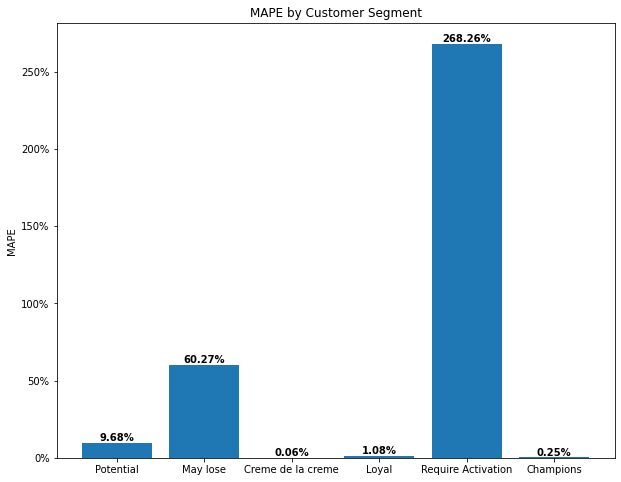

In [ ]:
# Because some customers are not regular. What we want to checj is the score by Customer Segment
# We see that the best customers, can be predicted with higher accuracy since they have a higher frequency
# Also, recency helps us when its higher because it gives us a larger time window for studying our client's

segments = ['Potential', 'May lose', 'Creme de la creme', 'Loyal','Require Activation', 'Champions']

mape_values = []

for seg in segments:
    seg_data = summary[summary['rfm_level'] == seg]
    mape = mean_absolute_percentage_error(seg_data['monetary_value'], seg_data['exp_avg_rev'])
    mape_values.append(mape)

    print('MAPE of {} is: {:.2%}'.format(seg, mape))

print()
print()
print()

fig, ax = plt.subplots(figsize=(10, 8))
x_pos = np.arange(len(segments))
ax.bar(x_pos,mape_values)
ax.set_xticks(x_pos)
ax.set_xticklabels(segments)
ax.set_ylabel('MAPE')
ax.set_title('MAPE by Customer Segment')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
for i, v in enumerate(mape_values):
    ax.text(i, v, '{:.2%}'.format(v), ha='center', va='bottom', fontweight='bold')
plt.show()


In [ ]:
# We now can see the final dataframe for making a data driven strategy with CLV and RFM

summary.head()

,client_id,frequency,recency,T,monetary_value,predict_purch_60,exp_avg_rev,avg_rev,error_rev,CLV,rfm_level
0,6,12.000,655.000,695.000,377.012,1.052,386.340,377.012,9.328,406.279,Potential
1,7,1.000,161.000,433.000,481.204,0.181,569.139,481.204,87.935,102.948,May lose
2,14,504.000,725.000,727.000,"6,246.709",41.121,"6,245.405","6,246.709",-1.304,"256,818.499",Creme de la creme
3,18,290.000,716.000,726.000,846.982,23.359,847.159,846.982,0.177,"19,788.565",Creme de la creme
4,37,14.000,568.000,677.000,428.392,1.190,435.922,428.392,7.530,518.827,Potential


### PRODUCT ANALYSIS, TOP 100 SELLING PRODUCTS OF 2019

In order to analyze product associations, we decided to refine our selection criteria.

To align with current customer preferences, we selected products that were sold exclusively in 2019 and were among the top 100 based on sales_net.

Once we had identified these 100 products, we used all transactions in which they appeared to create a model using the Apriori algorithm for basket analysis.

In [ ]:
all_data.nunique()

date_order                      731
product_id                   605575
client_id                    170586
sales_net                   1994303
quantity                       3413
order_channel                     5
branch_id                       582
cumulative_sales_net         360640
cumulative_sales_net_pct     352522
ABC_group                         3
dtype: int64

In [ ]:
all_data = all_data[all_data['date_order'] >= '01/01/2019']

In [ ]:
grouped = all_data\
          .groupby(['product_id'])\
          .agg({'sales_net':'sum', 'quantity': 'sum'})\
          .reset_index()\
          .sort_values(by='sales_net', ascending=False)

grouped['cumulative_sales_net'] = grouped['sales_net'].cumsum()
grouped['cumulative_sales_net_pct'] = grouped['cumulative_sales_net'] / grouped['sales_net'].sum() * 100

In [ ]:
grouped.head()

,product_id,sales_net,quantity,cumulative_sales_net,cumulative_sales_net_pct
276025,2681878,"16,580,618.000",30845939,"16,580,618.000",0.452
47338,463156,"10,092,385.000",28023647,"26,673,004.000",0.728
261694,2542409,"10,003,078.000",14795703,"36,676,080.000",1.001
136024,1325810,"8,296,842.000",18603140,"44,972,920.000",1.227
128602,1253061,"7,880,937.000",168095,"52,853,856.000",1.442


In [ ]:
df_100 = grouped.head(100)
df_100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 276025 to 147460
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   product_id                100 non-null    int64  
 1   sales_net                 100 non-null    float32
 2   quantity                  100 non-null    int32  
 3   cumulative_sales_net      100 non-null    float32
 4   cumulative_sales_net_pct  100 non-null    float32
dtypes: float32(3), int32(1), int64(1)
memory usage: 3.1 KB


In [ ]:
df_100.tail(1)

,product_id,sales_net,quantity,cumulative_sales_net,cumulative_sales_net_pct
147460,1437249,"1,905,270.375",3777799,"340,282,112.000",9.283


In [ ]:
top_100_transactions = all_data[all_data['product_id'].isin(df_100['product_id'])]
top_100_transactions.nunique()

date_order                     265
product_id                     100
client_id                    75113
sales_net                   176391
quantity                       789
order_channel                    4
branch_id                      540
cumulative_sales_net           100
cumulative_sales_net_pct       100
ABC_group                        1
dtype: int64

### ASSOCIATION RULES FOR TOP_100 PRODUCTS OF 2019



Resources: https://gaoxiangluo.github.io/2020/10/14/Association-Rules-Basic-Concept/

In [ ]:
%reset_selective -f all_data
%reset_selective -f refunds
%reset_selective -f df_labeled
%reset_selective -f grouped

In [ ]:
top_100_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1658466 entries, 37044648 to 58514559
Data columns (total 10 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   date_order                1658466 non-null  datetime64[ns]
 1   product_id                1658466 non-null  int32         
 2   client_id                 1658466 non-null  int32         
 3   sales_net                 1658466 non-null  float32       
 4   quantity                  1658466 non-null  int32         
 5   order_channel             1658466 non-null  category      
 6   branch_id                 1658466 non-null  int16         
 7   cumulative_sales_net      1658466 non-null  float32       
 8   cumulative_sales_net_pct  1658466 non-null  float32       
 9   ABC_group                 1658466 non-null  object        
dtypes: category(1), datetime64[ns](1), float32(3), int16(1), int32(3), object(1)
memory usage: 80.7+ MB


In [ ]:
top_100_transactions['trans_id'] = top_100_transactions['date_order'].astype('str') + '_' + top_100_transactions['client_id'].astype('str')
top_100_transactions['trans_id'] = top_100_transactions['trans_id'].astype('category')

In [ ]:
#here we will optimise the dataset and also create some new features. Although these features will not be used for now

top_100_transactions.drop(['ABC_group', 'cumulative_sales_net', 'cumulative_sales_net_pct', 'branch_id', 'order_channel','client_id' ], axis = 1, inplace = True)
top_100_transactions.head()

,date_order,product_id,sales_net,quantity,trans_id
37044648,2019-01-01,738406,6.164,5,2019-01-01_847593
37047426,2019-01-01,2354998,23.536,9,2019-01-01_2053450
37048328,2019-01-01,2542409,144.700,201,2019-01-01_1363000
37048332,2019-01-01,2198494,59.202,9,2019-01-01_958307
37051197,2019-01-01,2542409,250.312,401,2019-01-01_202592


In [ ]:
#checking for memory usage after the above optimisation

print(f'The dataframe is now using {top_100_transactions.memory_usage(deep=True).sum()/1e+9} GB memory')

The dataframe is now using 0.12717545 GB memory


In [ ]:
import gc
gc.collect()

11402

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

min_support = float(0.01)
min_threshold = float(0.5)

# Group the data by transaction_id and cluster_family and sum the quantity values
grouped_data =top_100_transactions.groupby(['trans_id', 'product_id'])['quantity'].sum().to_frame().reset_index()

# Pivot the data to create a new dataframe with transaction_id as the rows and cluster_family as the columns
pivot_data = pd.pivot_table(grouped_data, index='trans_id', columns='product_id', values='quantity', fill_value=0)

# Transform the pivot data to a binary matrix where values greater than 0 are set to 1
pivot_data = pivot_data.apply(lambda x: x > 0)

# Use the apriori function to generate the frequent item sets
freq_items = apriori(pivot_data, min_support=min_support, use_colnames=True, max_len=3)

# Use the association_rules function to generate the association rules
assoc_rules = association_rules(freq_items, min_threshold=min_threshold)

# Print the association rules
assoc_rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(1696760),(123753),0.051,0.037,0.026,0.521,14.085,0.024,2.012
1,(123753),(1696760),0.037,0.051,0.026,0.711,14.085,0.024,3.289
2,(2034528),(123753),0.025,0.037,0.015,0.606,16.375,0.014,2.446
3,(463156),(2681878),0.021,0.021,0.011,0.556,26.371,0.011,2.206
4,(2681878),(463156),0.021,0.021,0.011,0.544,26.371,0.011,2.146
5,(738406),(1390401),0.112,0.175,0.085,0.755,4.324,0.065,3.370
6,(2734140),(738406),0.087,0.112,0.045,0.522,4.657,0.035,1.858
7,(897228),(1575356),0.032,0.055,0.016,0.508,9.289,0.014,1.921
8,(1438570),(1180925),0.038,0.038,0.032,0.842,21.894,0.031,6.087
9,(1180925),(1438570),0.038,0.038,0.032,0.834,21.894,0.031,5.791


In [ ]:
pd.options.display.max_columns = None
pivot_data.head()

product_id,11100,45063,59473,62312,64914,85044,123753,135781,199095,288176,378845,417321,447463,463156,517859,547877,555160,560204,572469,579087,592053,642862,653092,738406,796395,829020,861224,875236,897228,915256,954487,1073087,1078192,1099102,1142551,1167515,1180925,1193732,1199641,1253061,1269067,1285627,1325810,1333056,1336760,1390401,1437249,1438570,1438905,1442712,1461750,1493262,1505281,1542607,1575356,1576245,1579529,1667065,1696760,1708877,1745137,1840980,1847827,1848537,1862474,1897903,1938504,1954776,2008648,2030665,2034528,2077753,2130816,2179351,2198494,2216854,2311274,2354998,2376333,2407904,2420503,2435294,2542409,2564840,2681878,2732769,2734140,2762192,2762529,2772519,2811661,2937553,2938723,2975027,2995747,3000560,3106953,3122216,3152916,3216624
trans_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01_1000147,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
2019-01-01_1000223,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2019-01-01_1001125,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2019-01-01_1001126,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2019-01-01_1001944,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
freq_items.head(10)

,support,itemsets
0,0.015,(45063)
1,0.037,(123753)
2,0.023,(378845)
3,0.012,(417321)
4,0.039,(447463)
5,0.021,(463156)
6,0.036,(517859)
7,0.015,(547877)
8,0.010,(560204)
9,0.022,(572469)


In [ ]:
confidence_association = association_rules(freq_items, metric='confidence', min_threshold=0.5)

In [ ]:
confidence_association.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(1696760),(123753),0.051,0.037,0.026,0.521,14.085,0.024,2.012
1,(123753),(1696760),0.037,0.051,0.026,0.711,14.085,0.024,3.289
2,(2034528),(123753),0.025,0.037,0.015,0.606,16.375,0.014,2.446
3,(463156),(2681878),0.021,0.021,0.011,0.556,26.371,0.011,2.206
4,(2681878),(463156),0.021,0.021,0.011,0.544,26.371,0.011,2.146
5,(738406),(1390401),0.112,0.175,0.085,0.755,4.324,0.065,3.370
6,(2734140),(738406),0.087,0.112,0.045,0.522,4.657,0.035,1.858
7,(897228),(1575356),0.032,0.055,0.016,0.508,9.289,0.014,1.921
8,(1438570),(1180925),0.038,0.038,0.032,0.842,21.894,0.031,6.087
9,(1180925),(1438570),0.038,0.038,0.032,0.834,21.894,0.031,5.791


In [ ]:
lift_association = association_rules(freq_items, metric="lift", min_threshold=1)

In [ ]:
lift_association.shape

(82, 9)

In [ ]:
lift_association.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(1696760),(123753),0.051,0.037,0.026,0.521,14.085,0.024,2.012
1,(123753),(1696760),0.037,0.051,0.026,0.711,14.085,0.024,3.289
2,(2034528),(123753),0.025,0.037,0.015,0.606,16.375,0.014,2.446
3,(123753),(2034528),0.037,0.025,0.015,0.402,16.375,0.014,1.632
4,(3216624),(123753),0.050,0.037,0.017,0.332,8.960,0.015,1.441
5,(123753),(3216624),0.037,0.050,0.017,0.449,8.960,0.015,1.723
6,(463156),(2681878),0.021,0.021,0.011,0.556,26.371,0.011,2.206
7,(2681878),(463156),0.021,0.021,0.011,0.544,26.371,0.011,2.146
8,(517859),(738406),0.036,0.112,0.013,0.348,3.103,0.009,1.361
9,(738406),(517859),0.112,0.036,0.013,0.113,3.103,0.009,1.086


In [ ]:
redundancy = lift_association.sort_values(by=['leverage','confidence'],axis=0, ascending=False).reset_index()
redundancy = redundancy.drop(['index'], axis=1)
redundancy.shape
redundancy.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(738406),(1390401),0.112,0.175,0.085,0.755,4.324,0.065,3.370
1,(1390401),(738406),0.175,0.112,0.085,0.485,4.324,0.065,1.723
2,(2734140),(738406),0.087,0.112,0.045,0.522,4.657,0.035,1.858
3,(738406),(2734140),0.112,0.087,0.045,0.403,4.657,0.035,1.530
4,(1745137),(2354998),0.060,0.066,0.038,0.627,9.534,0.034,2.502
5,(2354998),(1745137),0.066,0.060,0.038,0.576,9.534,0.034,2.215
6,(2734140),(1390401),0.087,0.175,0.048,0.557,3.189,0.033,1.863
7,(1390401),(2734140),0.175,0.087,0.048,0.276,3.189,0.033,1.262
8,(2354998),(1390401),0.066,0.175,0.044,0.672,3.850,0.033,2.519
9,(1390401),(2354998),0.175,0.066,0.044,0.253,3.850,0.033,1.251


In [ ]:
unique_rules = redundancy.iloc[::2]
unique_rules.shape

(41, 9)

In [ ]:
unique_rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(738406),(1390401),0.112,0.175,0.085,0.755,4.324,0.065,3.370
2,(2734140),(738406),0.087,0.112,0.045,0.522,4.657,0.035,1.858
4,(1745137),(2354998),0.060,0.066,0.038,0.627,9.534,0.034,2.502
6,(2734140),(1390401),0.087,0.175,0.048,0.557,3.189,0.033,1.863
8,(2354998),(1390401),0.066,0.175,0.044,0.672,3.850,0.033,2.519
10,"(1390401, 2734140)",(738406),0.048,0.112,0.038,0.783,6.986,0.032,4.095
12,(1862474),(1180925),0.036,0.038,0.034,0.937,24.375,0.032,15.376
14,(1438570),(1180925),0.038,0.038,0.032,0.842,21.894,0.031,6.087
16,"(1390401, 738406)",(2734140),0.085,0.087,0.038,0.446,5.152,0.030,1.648
18,"(2734140, 738406)",(1390401),0.045,0.175,0.038,0.835,4.784,0.030,5.015


In [ ]:
top = unique_rules[unique_rules['lift']>1.5]

In [ ]:
top.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 0 to 80
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         41 non-null     object 
 1   consequents         41 non-null     object 
 2   antecedent support  41 non-null     float64
 3   consequent support  41 non-null     float64
 4   support             41 non-null     float64
 5   confidence          41 non-null     float64
 6   lift                41 non-null     float64
 7   leverage            41 non-null     float64
 8   conviction          41 non-null     float64
dtypes: float64(7), object(2)
memory usage: 3.2+ KB


In [ ]:
top_sort = top.sort_values(by='lift', ascending=False)
top_sort.reset_index(inplace=True)
top_sort = top_sort.drop(['index'],axis=1)
top_sort.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(463156),(2681878),0.021,0.021,0.011,0.556,26.371,0.011,2.206
1,"(1438570, 1180925)",(1862474),0.032,0.036,0.030,0.928,25.823,0.029,13.385
2,"(1862474, 1438570)",(1180925),0.030,0.038,0.030,0.977,25.393,0.029,41.118
3,(1862474),(1180925),0.036,0.038,0.034,0.937,24.375,0.032,15.376
4,"(1862474, 1180925)",(1438570),0.034,0.038,0.030,0.883,23.194,0.028,8.250
5,(1862474),(1438570),0.036,0.038,0.030,0.848,22.265,0.029,6.328
6,(1438570),(1180925),0.038,0.038,0.032,0.842,21.894,0.031,6.087
7,"(2034528, 1696760)",(123753),0.016,0.037,0.013,0.800,21.599,0.012,4.808
8,(915256),(2995747),0.022,0.024,0.010,0.467,19.409,0.010,1.830
9,(2034528),"(1696760, 123753)",0.025,0.026,0.013,0.509,19.334,0.012,1.984


### GRAPH ANALYSIS FOR ASSOCIATION RULES VISUALIZATION

In [ ]:
import networkx as nx

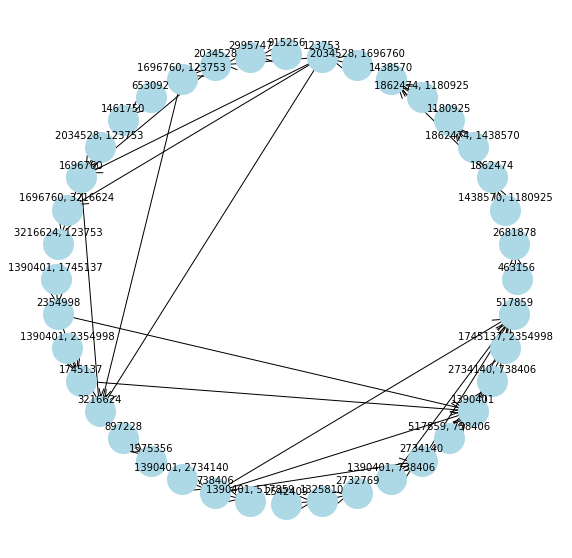

In [ ]:
# Define the graph and layout
G_rules = nx.from_pandas_edgelist(top_sort, source='antecedents', target='consequents', edge_attr='support')
plt.figure(figsize = (10,10))
pos = nx.circular_layout(G_rules)

# Draw the nodes and edges
nx.draw_networkx_nodes(G_rules, pos, node_color='lightblue', node_size=900)
nx.draw_networkx_edges(G_rules, pos, arrows=True, arrowstyle='->', arrowsize=30, edge_color='black', width=1)

# Add labels to the nodes
labels = {node: node for node in G_rules.nodes}
labels = {node: ', '.join(str(x) for x in list(node)[0:2]) for node in G_rules.nodes}
node_label_pos = {k: [v[0], v[1] + 0.05] for k, v in pos.items()}
nx.draw_networkx_labels(G_rules, node_label_pos, labels, font_size=10, font_color='black')

plt.axis('off')
plt.show()


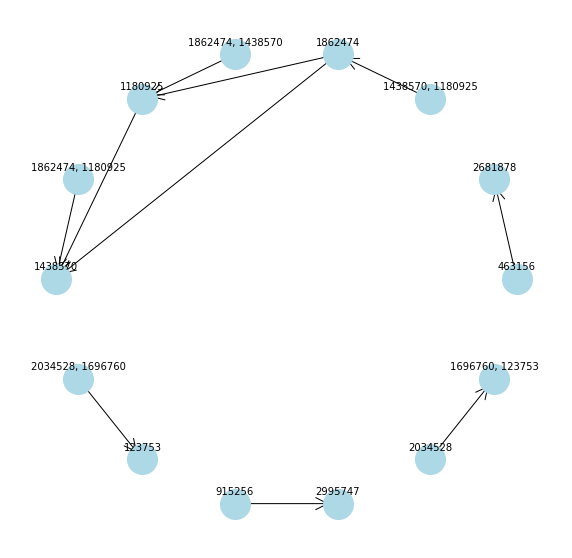

In [ ]:
# Define the graph and layout
G_rules = nx.from_pandas_edgelist(top_sort.head(10), source='antecedents', target='consequents', edge_attr='support')
plt.figure(figsize = (10,10))
pos = nx.circular_layout(G_rules)

# Draw the nodes and edges
nx.draw_networkx_nodes(G_rules, pos, node_color='lightblue', node_size=900)
nx.draw_networkx_edges(G_rules, pos, arrows=True, arrowstyle='->', arrowsize=30, edge_color='black', width=1)

# Add labels to the nodes
labels = {node: node for node in G_rules.nodes}
labels = {node: ', '.join(str(x) for x in list(node)[0:2]) for node in G_rules.nodes}
node_label_pos = {k: [v[0], v[1] + 0.05] for k, v in pos.items()}
nx.draw_networkx_labels(G_rules, node_label_pos, labels, font_size=10, font_color='black')

plt.axis('off')
plt.show()


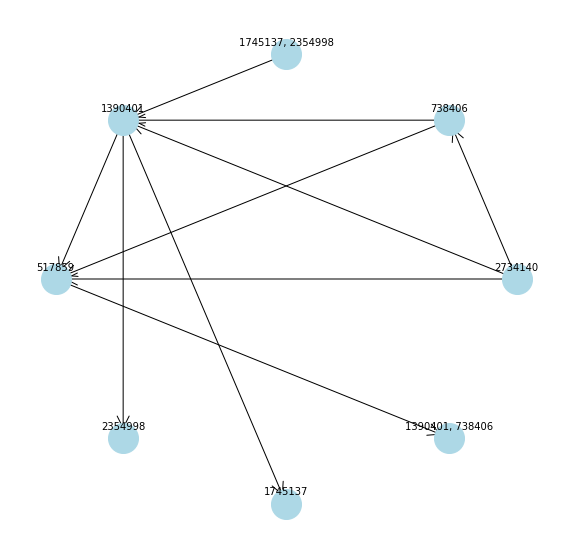

In [ ]:
# Define the graph and layout
G_rules = nx.from_pandas_edgelist(top_sort.tail(10), source='antecedents', target='consequents', edge_attr='support')
plt.figure(figsize = (10,10))
pos = nx.circular_layout(G_rules)

# Draw the nodes and edges
nx.draw_networkx_nodes(G_rules, pos, node_color='lightblue', node_size=900)
nx.draw_networkx_edges(G_rules, pos, arrows=True, arrowstyle='->', arrowsize=30, edge_color='black', width=1)

# Add labels to the nodes
labels = {node: node for node in G_rules.nodes}
labels = {node: ', '.join(str(x) for x in list(node)[0:2]) for node in G_rules.nodes}
node_label_pos = {k: [v[0], v[1] + 0.05] for k, v in pos.items()}
nx.draw_networkx_labels(G_rules, node_label_pos, labels, font_size=10, font_color='black')

plt.axis('off')
plt.show()

### ADDITIONAL APPROACH FOR FREQUENT ITEM SETS (MANUAL ASSOCIATION)

In [ ]:
#create grouped col 
top_100_transactions['product_id'] = top_100_transactions['product_id'].astype(str)
top_100_transactions['Grouped'] = top_100_transactions.groupby('trans_id')['product_id'].transform(lambda x: ','.join(x))
#lets drop out all duplicate Order ID
top_100_transactions_2 = top_100_transactions.drop_duplicates(subset=['trans_id'])

In [ ]:
# Referenced: https://stackoverflow.com/questions/52195887/counting-unique-pairs-of-numbers-into-a-python-dictionary
import itertools 
from itertools import combinations
from collections import Counter

count = Counter()

for row in top_100_transactions_2['Grouped']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))

for key,value in count.most_common(10):
    item_sets =  print(key, value)


('1390401', '738406') 49771
('738406', '1390401') 48607
('1336760', '1336760') 35321
('1390401', '1390401') 31856
('2354998', '1390401') 29909
('1390401', '2734140') 28304
('1745137', '1390401') 28211
('1390401', '2354998') 27406
('2734140', '1390401') 27191
('954487', '954487') 26992


# DATA SAVING (ONLY RUN WHEN NEEDED)

REFUNDS DATA READY FOR ANALYSIs

In [ ]:
refunds.to_csv('/content/drive/MyDrive/capstone/refunds.csv', index=False, sep=';', encoding='utf-8')

ALL TRANSACTIONS WITH THE PRODUCT SEGMENTS ASSIGNED

In [ ]:
all_data.to_csv('/content/drive/MyDrive/capstone/all_transactions_clean_checked.csv', index=False, sep=';', encoding='utf-8')

TOP_100 PRODUCTS OF 2019 WITH ALL THEIR TRANSACTIONS READY FOR APRIORI MODELING

In [ ]:
top_100_transactions.to_csv('/content/drive/MyDrive/capstone/apriori_data_2019prods.csv', index=False, sep=';', encoding='utf-8')